# Amazon Products Reviews Classification

![](https://wallsdesk.com/wp-content/uploads/2016/10/Amazon-Wallpapers.jpg)

### Contents
- Abstract
- Dataset
- Goal
1. Preparation
    - Packages
    - Loading Dataset
2. Text Features
    - CountVectorizer + MultinomialNB
    - TfidfVectorizer + MultinomialNB
    - CountVectorizer + MultinomialNB w/o stopwords
    - TfidfVectorizer + MultinomialNB w/o stopwords
    - CountVectorizer + MultinomialNB lemmatized
    - Model Comparison
3. Deep Learning
    - LSTM
    - RoBERTa
    - Model Comparison
4. Overall Comparison
5. Conclusion

****************************************

### Abstract
Amazon.com, Inc. (/ˈæməzɒn/ AM-ə-zon) is an American multinational technology company which focuses on e-commerce, cloud computing, digital streaming, and artificial intelligence. It is one of the Big Five companies in the U.S. information technology industry, along with Google, Apple, Microsoft, and Facebook. The company has been referred to as "one of the most influential economic and cultural forces in the world", as well as the world's most valuable brand.

Jeff Bezos founded Amazon from his garage in Bellevue, Washington,on July 5, 1994. It started as an online marketplace for books but expanded to sell electronics, software, video games, apparel, furniture, food, toys, and jewelry. In 2015, Amazon surpassed Walmart as the most valuable retailer in the United States by market capitalization. In 2017, Amazon acquired Whole Foods Market for US$13.4 billion, which substantially increased its footprint as a physical retailer. In 2018, its two-day delivery service, Amazon Prime, surpassed 100 million subscribers worldwide.

Sentiment analysis is a NLP task which aims to classify a text based on the sentiment it conveys, aka its *polarity* (whether it is positive, neutral or negative). A typical business-oriented application is to analyze product reviews and customer feedbacks.

The dataset which we investigate contains tens of thousands of Amazon reviews, which have been labeled as positive or negative by looking at the score given by users. We show different approaches to the problem of sorting them in the correct class based on the content of the review, both using text-feature extraction and deep learning. 

### Dataset
The dataset is collected from the Kaggle website. Here is the link : https://www.kaggle.com/kritanjalijain/amazon-reviews?select=train.csv

### Goal
The goal of this project is to make a classifiation model which will classify the products review enlisted in the Amazon Inc website, so that it can help the company for their betterment, and also they can rectify their faults depending on the users' experience.
*********************************************

## 1. Preparation <a id=1></a>

### 1.1 Packages <a id=1.1></a>

In [1]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

import nltk
from nltk.corpus import stopwords
import spacy
import langid

import plotly
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

init_notebook_mode(connected=True)
cf.set_config_file(sharing='public',theme='white',offline=True)

import fastbook
fastbook.setup_book()

from fastai.text.all import *
from fastbook import *
    
warnings.filterwarnings(action='ignore', category=UserWarning)

### 1.2 Data <a id=1.2></a>

In [2]:
train_df = pd.read_csv('../input/amazon-reviews/train.csv', header=None, names=['label', 'title', 'text'])
test_df = pd.read_csv('../input/amazon-reviews/test.csv', header=None, names=['label', 'title', 'text'])

The two dataframes have three columns:

`label` - Target variable with two categorical levels: 1 if the review is negative (1/2 stars rating); 2 if the review is positive (4/5 stars rating).

`title` - Heading of the review.

`text` - Body of the review.

Since the original dataset is huge, for time and memory contsraints **we will restrict to a random subset of 50000 rows from `train_df` and 10000 rows from `test_df`**, which will be respectively our training and validation set. We select such subsets randomly and so that their are both perfectly balanced. We also merge the `title` and `text` features in a single `text` column.

In [20]:
train_df['title'].fillna('', inplace=True)
test_df['title'].fillna('', inplace=True)

train_len = 50000
test_len = 10000
rs = 42

df = pd.concat([train_df.loc[train_df['label'] == 1].sample(train_len//2, random_state=rs),
                train_df.loc[train_df['label'] == 2].sample(train_len//2, random_state=rs),
                test_df.loc[test_df['label'] == 1].sample(test_len//2, random_state=rs),
                test_df.loc[test_df['label'] == 2].sample(test_len//2, random_state=rs)]).reset_index(drop=True)
df['text'] = df['title'] + '. ' + df['text']
df.drop('title', axis=1, inplace=True)
df.head()

,label,text
0,1,"The History of Torture and Execution. I have not yet received the book ordered even though, I paid a rather high price for it. I have been unable to get a response from the seller, and am beginning to think that they may be something ""less than reputable"".James J. EbyRATING- ""ZERO STARS""!"
1,1,"Stainless Steel shouldn't corrode... should it?. We were really pleased when we first received and used this knife set. Its appearance was very professional, the handles very user friendly, and the edges were VERY sharp. However, after using the set and following the care directions for a few months, it became apparent that something was VERY wrong. The 3 1/4"" and 5"" blades started to show black spots and then began to corrode. Now the 3 1/4"" paring knife blade has so much decay that it can be nearly described as a serrated blade. The manufacturer offers a ""limited lifetime warranty"" so we..."
2,1,Another Weak Sequel To A Once Promising Franchise. Hellraiser: Heatseeker is a film that I wanted to enjoy. I thought the first direct to video Hellraiser sequel was decent but this one is just patheic consdering it has Ashley Laurence in it. I would only say you see this film if you need a movie to fall asleep on.
3,1,"Simply Awful. Contrived, trite, ""Bridget Jones's Diary"" wannabe. So glad that I borrowed this from the library and did not spend hard-earned cash. A frivolous story about a London plain Jane and her struggles to land the boy - and career - of her dreams. 291 pages of pure fluff."
4,1,"FLASH. Jeff Beck's Flash In my opinion, was not one of his better albums.""Gets us all in the end"" is a hard driving rocker.""People Get Ready"" with Rod Stewart on vocals is a Classic!Take these 2 tracks out of there, and this was a new sound experimentgone south! Too much of that New Wave sound which was becoming increasinglypopular in the 80's. Just not my cup of tea.But if that sound is you Go for it! Jeff Beck is still one of the All timebest Guitarist's that ever played an ax."


In [4]:
print(f'Label counts - training set:\n{df[:train_len].label.value_counts()}')
print(f'\nLabel counts - validation set:\n{df[train_len:].label.value_counts()}')

Label counts - training set:
2    25000
1    25000
Name: label, dtype: int64

Label counts - validation set:
2    5000
1    5000
Name: label, dtype: int64


## 2. Text Features <a id=2></a>

We first try classifying reviews using **text vectorization**: we split the text into tokens and, for each token in the corpus, we count how many times it appears in a review. The counts for each token become the numerical features which we feed to the model. As tokens we will use not only single words, aka 1-grams, but also 2-grams and 3-grams, i.e. sequences of contiguous words of length 2 and 3 respectively.

In [7]:
cv = CountVectorizer(ngram_range=(1,3))
cv.fit(df['text'])
print(f"Number of n-grams in the corpus: {len(cv.vocabulary_)}")

Number of n-grams in the corpus: 4212007


We see that our corpus contains more than four milion n-grams (for n = 1,2,3). Which are the most frequent ones?

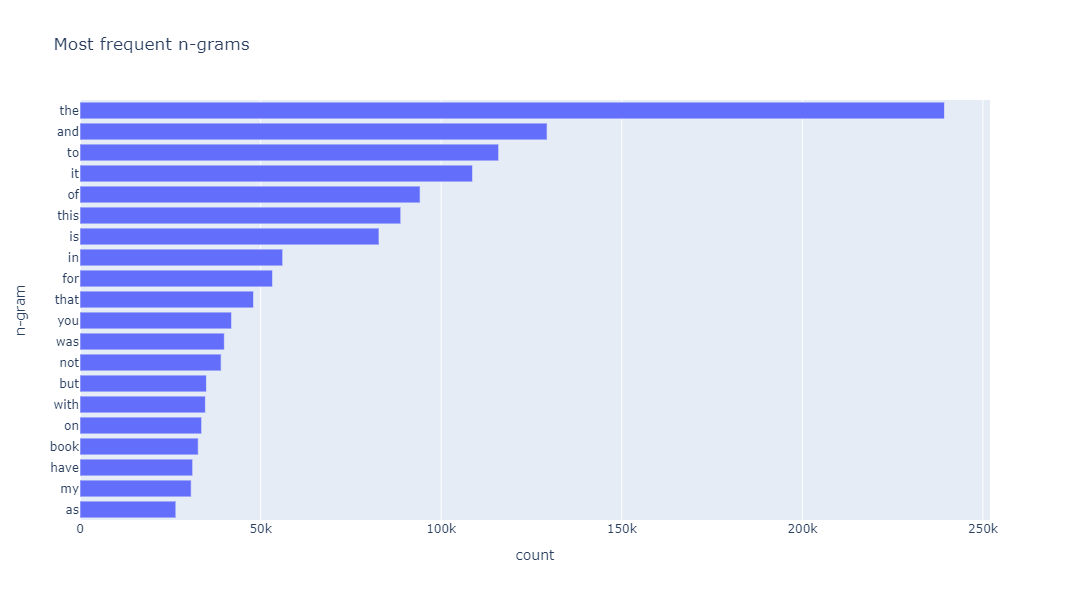

In [8]:
fts = cv.get_feature_names()
freq = cv.transform(df['text'])
gram_counts = np.array(freq.sum(0)).squeeze()

gram_counts_df = pd.DataFrame({'n-gram': [fts[i] for i in gram_counts.argsort()],
                               'count': sorted(gram_counts)})

px.bar(gram_counts_df[-20:], y='n-gram', x='count', title='Most frequent n-grams', orientation='h', height=600)

The 1-grams which appears more frequently in the corpus are unlikely to be particularly meaningful for the classification task at hand. This problem is usually tackled in two ways: we can either remove **stopwords** (i.e. the most frequent words in the language the review is written in, such as pronouns and conjunctions), or normalize the frequency counts based on how often each n-gram appears across the documents in the corpus, e.g. by using **tf-idf** vectorization, in order to penalize tokens that are common in both positive and negative reviews. 

Before trying any of these approaches, let us consider as baseline a simple multinomial naive Bayes model which uses the n-gram frequencies (n=1,2,3) from count vectorization as features.

Model: CountVectorizer + MultinomialNB
Number of features: 3615739
Accuracy: 0.8906

              precision    recall  f1-score   support

           1       0.87      0.92      0.89      5000
           2       0.92      0.86      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



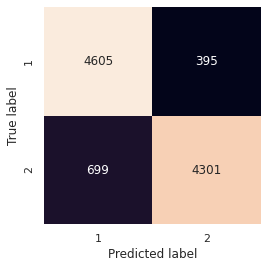

In [21]:
cv_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), MultinomialNB())

x_train, y_train = df['text'][:train_len], df['label'][:train_len].values.reshape(-1,1)
x_test, y_test = df['text'][train_len:], df['label'][train_len:].values.reshape(-1,1)

cv_model.fit(x_train, y_train)
preds = cv_model.predict(x_test)

print("Model: CountVectorizer + MultinomialNB")
print(f"Number of features: {len(cv_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=cv_model.classes_, yticklabels=cv_model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')

print(classification_report(y_test, preds, labels=cv_model.classes_))

Let's check now how tf-idf vectorization performs.

Model: TfidfVectorizer + MultinomialNB
Number of features: 3615739
Accuracy: 0.8908

              precision    recall  f1-score   support

           1       0.86      0.93      0.89      5000
           2       0.92      0.85      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



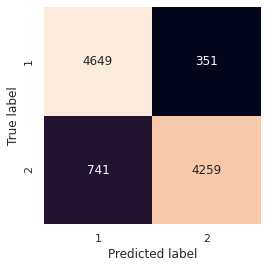

In [22]:
tfidf_model = make_pipeline(TfidfVectorizer(ngram_range=(1,3)), MultinomialNB())

tfidf_model.fit(x_train, y_train)
preds = tfidf_model.predict(x_test)

print("Model: TfidfVectorizer + MultinomialNB")
print(f"Number of features: {len(tfidf_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=tfidf_model.classes_, yticklabels=tfidf_model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')

print(classification_report(y_test, preds, labels=tfidf_model.classes_))

The two types of vectorization give very similar results. We can try removing stopwords before vectorizing: in order to do so, we need to understand which languages are present in the corpus of reviews. The most frequent n-grams all come from english, but there might also be reviews written in other languages. We use the `langid` library to predict the language of each review in our dataset.

In [11]:
langs = [langid.classify(s)[0] for s in df['text']]
Counter(langs)

Counter({'en': 59757,
         'es': 131,
         'no': 34,
         'et': 5,
         'pl': 9,
         'da': 2,
         'fr': 15,
         'mt': 14,
         'sv': 2,
         'it': 6,
         'tl': 1,
         'pt': 7,
         'de': 4,
         'af': 1,
         'se': 3,
         'fi': 2,
         'an': 3,
         'la': 1,
         'rw': 1,
         'sk': 1,
         'ky': 1})

Non-english reviews appear to be a very small minority, so we'll simply drop such samples from our dataset.

In [23]:
df = df[[l=='en' for l in langs]]

x_train, y_train = df['text'][:train_len], df['label'][:train_len].values.reshape(-1,1)
x_test, y_test = df['text'][train_len:], df['label'][train_len:].values.reshape(-1,1)

print(f'Label counts - training set:\n{df[:train_len].label.value_counts()}')
print(f'\nLabel counts - validation set:\n{df[train_len:].label.value_counts()}')

Label counts - training set:
1    25134
2    24866
Name: label, dtype: int64

Label counts - validation set:
2    4974
1    4783
Name: label, dtype: int64


Let us now try removing english stopwords from the corpus of reviews.

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of ngrams in the corpus w/o stopwords: 3680897


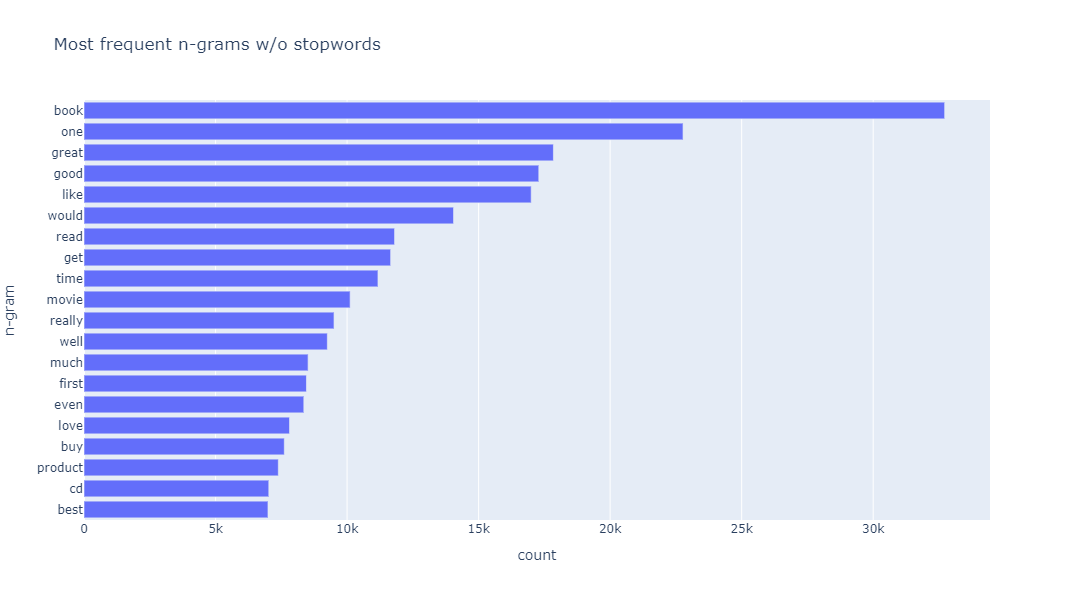

In [13]:
nltk.download('stopwords')
sw = stopwords.words('english')

cv = CountVectorizer(ngram_range=(1,3), stop_words=frozenset(sw))
cv.fit(df['text'])
print(f"Number of ngrams in the corpus w/o stopwords: {len(cv.vocabulary_)}")

fts = cv.get_feature_names()
freq = cv.transform(df['text'])
gram_counts = np.array(freq.sum(0)).squeeze()

gram_counts_df = pd.DataFrame({'n-gram': [fts[i] for i in gram_counts.argsort()],
                               'count': sorted(gram_counts)})

px.bar(gram_counts_df[-20:], y='n-gram', x='count', title='Most frequent n-grams w/o stopwords',
       orientation='h', height=600)

The resulting features are now much more likely to be meaningful to sentiment analysis for the reviewed products, in particular when considering 2-grams and 3-grams.

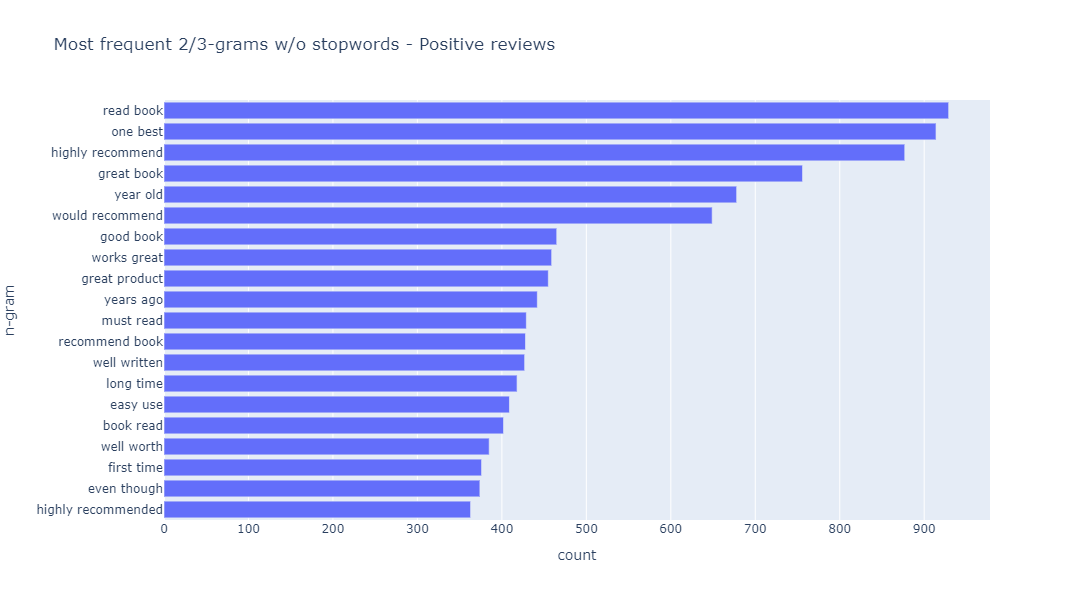

In [14]:
cv2 = CountVectorizer(ngram_range=(2,3), stop_words=frozenset(sw))
cv2.fit(df['text'])
fts2 = cv2.get_feature_names()

freq_pos = cv2.transform(df.loc[df['label'] == 2, 'text'])
gram_counts_pos = np.array(freq_pos.sum(0)).squeeze()

gram_counts_pos_df = pd.DataFrame({'n-gram': [fts2[i] for i in gram_counts_pos.argsort()],
                               'count': sorted(gram_counts_pos)})

px.bar(gram_counts_pos_df[-20:], y='n-gram', x='count', title='Most frequent 2/3-grams w/o stopwords - Positive reviews',
       orientation='h', height=600)

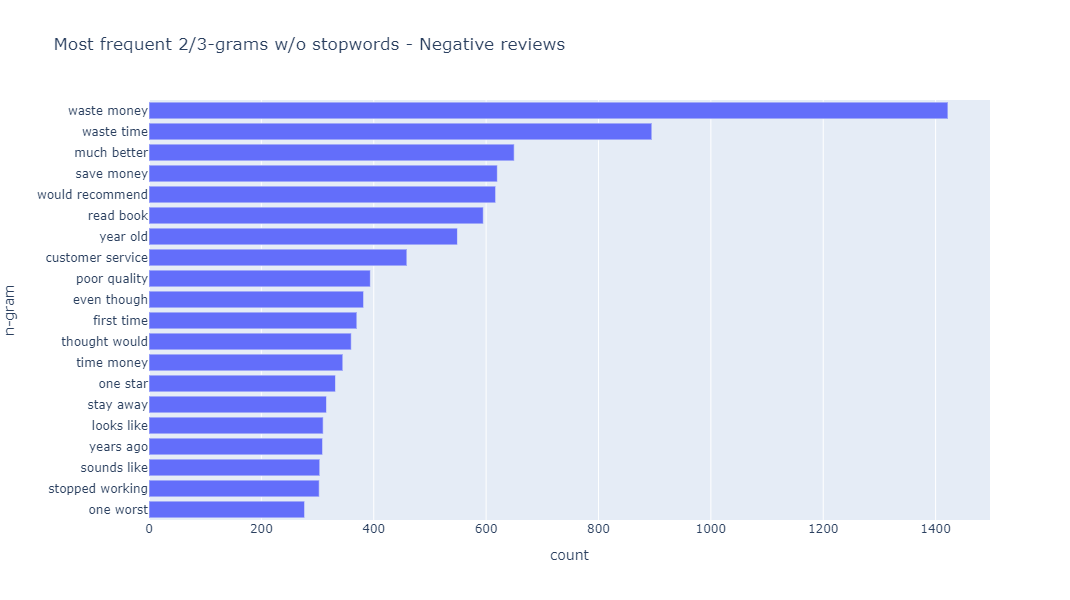

In [15]:
freq_neg = cv2.transform(df.loc[df['label'] == 1, 'text'])
gram_counts_neg = np.array(freq_neg.sum(0)).squeeze()
gram_counts_neg_df = pd.DataFrame({'n-gram': [fts2[i] for i in gram_counts_neg.argsort()],
                               'count': sorted(gram_counts_neg)})

px.bar(gram_counts_neg_df[-20:], y='n-gram', x='count', title='Most frequent 2/3-grams w/o stopwords - Negative reviews',
       orientation='h', height=600)

We need to be careful when removing stopwords. For instance, we see from the charts that 'would recommend' is a frequent 2-gram in both types of reviews, since 'not' is currently included in our stopword list and therefore 'would recommend' and 'would not recommend' become the same token! This is clearly something we do not want to happen: let us fix the problem by modifying the stopword list.

In [16]:
for a in [l for l in sw if l.endswith('n') or l.endswith("n't")][12:]:
    sw.remove(a)
sw.remove('no')
sw.remove('nor')
sw.remove('not')

Model: CountVectorizer + MultinomialNB w/o stopwords
Number of features: 3177717
Accuracy: 0.8763

              precision    recall  f1-score   support

           1       0.85      0.91      0.88      4783
           2       0.91      0.84      0.87      4974

    accuracy                           0.88      9757
   macro avg       0.88      0.88      0.88      9757
weighted avg       0.88      0.88      0.88      9757



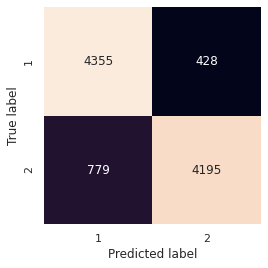

In [24]:
cvwosw_model = make_pipeline(CountVectorizer(ngram_range=(1,3), stop_words=frozenset(sw)), MultinomialNB())

cvwosw_model.fit(x_train, y_train)
preds = cvwosw_model.predict(x_test)

print("Model: CountVectorizer + MultinomialNB w/o stopwords")
print(f"Number of features: {len(cvwosw_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=cvwosw_model.classes_, yticklabels=cvwosw_model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')

print(classification_report(y_test, preds, labels=cvwosw_model.classes_))

Model: TfidfVectorizer + MultinomialNB w/o stopwords
Number of features: 3177717
Accuracy: 0.8759

              precision    recall  f1-score   support

           1       0.84      0.92      0.88      4783
           2       0.91      0.84      0.87      4974

    accuracy                           0.88      9757
   macro avg       0.88      0.88      0.88      9757
weighted avg       0.88      0.88      0.88      9757



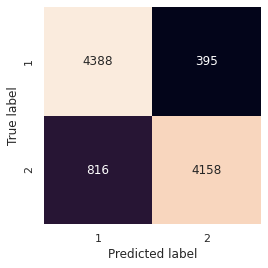

In [25]:
tfidfwosw_model = make_pipeline(TfidfVectorizer(ngram_range=(1,3), stop_words=frozenset(sw)), MultinomialNB())

tfidfwosw_model.fit(x_train, y_train)
preds = tfidfwosw_model.predict(x_test)

print("Model: TfidfVectorizer + MultinomialNB w/o stopwords")
print(f"Number of features: {len(tfidfwosw_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=tfidfwosw_model.classes_, yticklabels=tfidfwosw_model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')

print(classification_report(y_test, preds, labels=tfidfwosw_model.classes_))

Vectorization using all n-grams in the original corpus still provides a model with better accuracy. However, removing stopwords has the advantage of reducing the number of features. To this end, another approach which can be tried is **lemmatization**, i.e. substituting all words in the corpus with their lemma, grouping together all inflected forms of the same word.

In [19]:
spcy = spacy.load('en_core_web_sm')

x_train_lemm = x_train.apply(lambda x: ' '.join([w.lemma_ for w in spcy(x)]))
x_test_lemm = x_test.apply(lambda x: ' '.join([w.lemma_ for w in spcy(x)]))

Model: CountVectorizer + MultinomialNB lemmatized
Number of features: 3071622
Accuracy: 0.8848

              precision    recall  f1-score   support

           1       0.85      0.93      0.89      4783
           2       0.92      0.84      0.88      4974

    accuracy                           0.88      9757
   macro avg       0.89      0.89      0.88      9757
weighted avg       0.89      0.88      0.88      9757



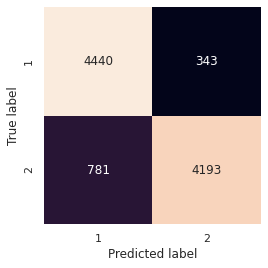

In [26]:
cvlemm_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), MultinomialNB())

cvlemm_model.fit(x_train_lemm, y_train)
preds = cvlemm_model.predict(x_test_lemm)

print("Model: CountVectorizer + MultinomialNB lemmatized")
print(f"Number of features: {len(cvlemm_model[0].vocabulary_)}")
print("Accuracy: {:.4f}\n".format(accuracy_score(y_test, preds)))
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=cvlemm_model.classes_, yticklabels=cvlemm_model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')

print(classification_report(y_test, preds, labels=cvlemm_model.classes_))

Lemmatizing gives better results than removing stopwords, and it further reduces the number of features. However, the accuracy is still not as good as compared to using the original text.

*****************************
### Model Comaprison
So far, we have developed **Text Vectorization Models**, and the models are now being checked by their accuracy scores. So, let's get to the comaparison of the deployed models.

|Models|Accuracy Score|
|:-:|:-:|
|CountVectorizer + MultinomialNB|89.06|
|TfidfVectorizer + MultinomialNB|89.08|
|CountVectorizer + MultinomialNB w/o stopwords|87.63|
|TfidfVectorizer + MultinomialNB w/o stopwords|87.59|
|CountVectorizer + MultinomialNB lemmatized|88.48|

### Observation
As the accuracy score provides that the Lemmatizing provides better results than removing stopwords, and it further reduces the number of features. However, the accuracy is still not as good as compared to using the original text.

Now let's get into the Deep Learning methods...
******************************

## 3. Deep Learning <a id=3></a>

Neural networks have proved to be extremely effective tools for NLP tasks. They generally provide significant improvements compared to standard ML models based on text features, even with minimal preprocessing (tokenization and numericalization of tokens is often enough). We will deploy two different models: one based on a Long Short-Term Memory (LSTM) recurrent neural network architecture and one using a state of the art transformer architecture. We will use PyTorch + fastai for implementation, together with huggingface Transformers library.

### 3.1 LSTM <a id=3.1></a>

We use the `AWD-LSTM` architecture.

We first finetune on our corpus the **language model** (whose task is predicting the next token in the text based on the previous ones), before using it to build a classifier (*transfer learning*). Preprocessing is done by tokenizing with SpaCy and adding special tokens for capitalization, repetitions, beginning of strings, etc.

In [28]:
lm_dblock = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                   get_x=ColReader('text'),
                   splitter=IndexSplitter(range(train_len, len(df))))
lm_dls = lm_dblock.dataloaders(df, bs=32, seq_len=72)

lm_dls.show_batch(dataloaders=lm_dls, max_n=4)

,text,text_
0,"xxbos a xxmaj true xxmaj star . i thought xxmaj fantasia was awesome on xxmaj american xxmaj idol , but i was not expecting this ! xxmaj she truely is a star with an impeccable voice . xxmaj she bares her soul and lets her voice be heard . xxmaj if you have n't watched xxmaj american xxmaj idol before , let this be the first person you listen to because this","a xxmaj true xxmaj star . i thought xxmaj fantasia was awesome on xxmaj american xxmaj idol , but i was not expecting this ! xxmaj she truely is a star with an impeccable voice . xxmaj she bares her soul and lets her voice be heard . xxmaj if you have n't watched xxmaj american xxmaj idol before , let this be the first person you listen to because this girl"
1,"fastest xxunk utilities available . xxmaj in addition the ability to configure the software to xxunk your drives while the computer is idle ( during a screen saver running for example ) makes this a great tool for your xxup pc toolbox . xxmaj in any event , do n't take my word for it . xxmaj you can download free xxunk at xxrep 3 w xxunk and try it for 30","xxunk utilities available . xxmaj in addition the ability to configure the software to xxunk your drives while the computer is idle ( during a screen saver running for example ) makes this a great tool for your xxup pc toolbox . xxmaj in any event , do n't take my word for it . xxmaj you can download free xxunk at xxrep 3 w xxunk and try it for 30 days"
2,"fans . xxmaj this video is a highlight film - not a complete video of the xxmaj super xxunk have a copy of the fabulous xxup xxunk xxmaj giants xxmaj super xxmaj bowl video . xxmaj it has all the playoff games , in their entirety . xxmaj this does n't even have the xxmaj super xxmaj bowl in its xxunk video should clearly state it is a "" highlight xxunk produce",". xxmaj this video is a highlight film - not a complete video of the xxmaj super xxunk have a copy of the fabulous xxup xxunk xxmaj giants xxmaj super xxmaj bowl video . xxmaj it has all the playoff games , in their entirety . xxmaj this does n't even have the xxmaj super xxmaj bowl in its xxunk video should clearly state it is a "" highlight xxunk produce a"
3,xxmaj there was a cool band that opened up the show called xxmaj too xxmaj bad xxmaj eugene and they were cool as a lang hole . mxpx took the show . xxbos xxmaj scary ! . i read this book back in the 1970 's when it was first published . xxmaj peter xxmaj straub reminded me very much of the way xxmaj stephen xxmaj king used to write back then,there was a cool band that opened up the show called xxmaj too xxmaj bad xxmaj eugene and they were cool as a lang hole . mxpx took the show . xxbos xxmaj scary ! . i read this book back in the 1970 's when it was first published . xxmaj peter xxmaj straub reminded me very much of the way xxmaj stephen xxmaj king used to write back then --


Fastai provides a very convenient *learning rate finder* to determine the best learning rate. The training of the neural network will be then performed using the **1cycle** policy (each epoch features a *warmup phase*, where the learning rate is gradually increased, followed by an *annealing phase*, where the lr decreases back to the minimum).

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.02290867641568184)

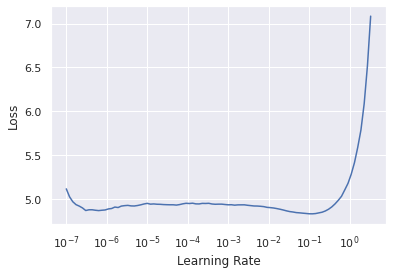

In [29]:
lm_learn = language_model_learner(lm_dls, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, perplexity])
lm_learn.lr_find()

In [32]:
lm_learn.fit_one_cycle(3, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.197454,4.089710,0.275483,59.722584,07:13
1,4.025518,3.992507,0.284328,54.190548,07:17
2,3.802304,3.954117,0.288181,52.149605,07:15


We save the weights in the body of the RNN and then move on to building the classifier.

In [33]:
lm_learn.save_encoder('lstm_finetuned')

clas_dblock = DataBlock(blocks=(TextBlock.from_df('text', vocab=lm_dls.vocab), CategoryBlock),
                        get_x=ColReader('text'), get_y=ColReader('label'),
                        splitter=IndexSplitter(range(train_len, len(df))))

clas_dls = clas_dblock.dataloaders(df, bs=32, seq_len=72, dl_type=SortedDL)

clas_dls.show_batch(dls=clas_dls, max_n=5)

,text,category
0,"xxbos xxup not xxup the xxup best xxup one , xxup but xxup close ( plus its only 12 bucks ) . … xxup the xxup audio xxup has xxup been xxup altered . xxup this xxup is xxup not xxup ac / xxup dc xxup live , xxup its xxup ac / xxup dc xxup xxunk . xxup the xxup nice xxup part xxup is xxup that xxup it xxup sounds xxup fantastic ! ! xxup the xxup audio xxup is xxup darn xxup near xxup perfect . xxup however , xxup the xxup video xxup quality xxup is xxup vhs xxup at xxup best , xxup the xxup blacks xxup look xxup grey xxup and xxup worn . xxup what xxup else xxup would xxup you xxup expect xxup from a 1991 xxup concert ? xxup some xxup remastering xxup would xxup have xxup been xxup nice .",2
1,"xxbos a solid debut album by an underappreciated musician . xxmaj la xxmaj toya 's self titled album is a solid effort . xxmaj with the exception of "" a xxmaj taste xxmaj of xxmaj love ( is a xxmaj taste xxmaj of xxmaj you ) "" , every other song suits xxmaj la xxmaj toya 's whispy vocals . i agree with the idea that xxmaj la xxmaj toya would have gained her most success as a xxmaj disco xxmaj diva because there were many successful female singers , both solo and in music groups or projects who had singing vocals similar to her own . xxmaj however , with the right lyrics and production to bring out the best of her voice , she can excel at both funky xxmaj dance songs and smooth xxmaj soul / xxmaj quiet xxmaj storm styled ballads . xxmaj an example of",2
2,"xxbos xxmaj buyer xxmaj be xxmaj very xxmaj wary . xxmaj the trusted leader in children 's learning really blew it with this product . i bought xxup ss xxmaj baby deluxe , xxup ss xxmaj preschool and xxup ss xxmaj toddler for my 2 and 4 year olds . xxmaj my little girl was xxup so excited to play these games but xxmaj uh - oh . xxmaj the small print says several of the disks xxup do n't xxup work on xxmaj windows 2 xxrep 3 0 and they were developed for xxup xp before the program was released so it is shaky on xxup xp machines too . xxmaj the bottom line - we ca n't run most of the cd 's - some will install but not play . xxmaj some wo n't give the sound , some wo n't install . xxmaj very disappointing .",1
3,"xxbos xxup jane 's xxup first xxup cd . xxup jane morgan 's xxup greatest xxup hits cd was her first ever material on cd and i had waited for it for some time . xxmaj it is a fine collection … except some one put the wrong version of "" two xxmaj different xxmaj worlds "" on the cd . i love both , but the cd liner notes mention xxup roger xxup williams ( another xxmaj xxunk artist ) on this one , but it is xxup the xxup troubadors instead . i would have traded xxmaj jane 's beautiful cover of "" kisses xxmaj sweeter xxmaj than xxmaj wine "" for "" it 's xxmaj all xxmaj in xxmaj the xxmaj game "" but it got more airplay when it was first released and is on a 45 . xxmaj the first song i ever remember hearing",2
4,"xxbos xxmaj why must they edit it so much ? . xxmaj okay before i give my reasons for xxup not liking this i must tell i have seen the xxup whole xxmaj japanese series of xxmaj dragonball xxup z. xxmaj therefore i know what was cutout and cleaned . xxmaj number xxunk xxmaj still dislike the voices , they all sound like cheesy xxmaj warner xxmaj bros . characters xxup especially xxmaj goku . xxmaj xxunk xxunk cut out any xxunk of xxunk me there 's a lot of xxmaj goku xxup naked in the xxmaj dragonball ) xxmaj also cut out are the actual xxup hits of the fighting , xxmaj example - when the little green guy from the xxmaj xxunk force is beating xxmaj xxunk and xxmaj gohan those puffy clouds are xxup not supposed to be there ! xxunk xxunk and change everything ! xxmaj",1


We load the language model weights in our classifier and then look for the best learning rate.

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.002511886414140463)

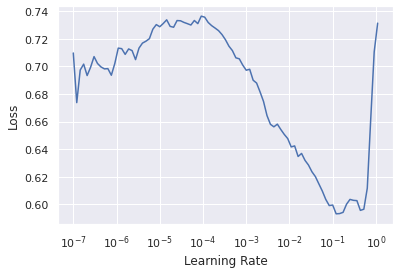

In [34]:
clas_learn = text_classifier_learner(clas_dls, AWD_LSTM, seq_len=72, metrics=accuracy)
clas_learn.load_encoder('lstm_finetuned')
clas_learn.freeze()

clas_learn.lr_find()

In order to train the classifier it is often a good choice to **gradually unfreeze** the layers of the NN, starting from training just the head (which at the moment contains random weights).

In [35]:
clas_learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.367207,0.289162,0.879881,02:25


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.0964781722577754e-06)

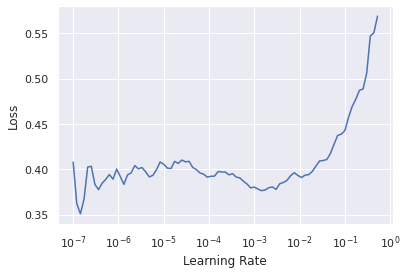

In [36]:
clas_learn.freeze_to(-2)
clas_learn.lr_find()

In [37]:
clas_learn.fit_one_cycle(1, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.342016,0.263415,0.892897,02:32


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=7.585775847473997e-07)

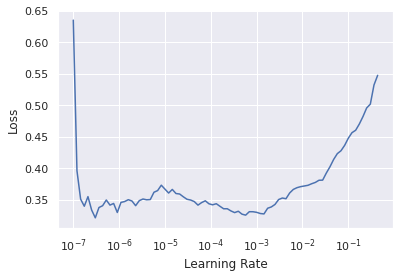

In [38]:
clas_learn.freeze_to(-3)
clas_learn.lr_find()

In [39]:
clas_learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.295854,0.239317,0.904274,03:12


We now unfreeze all remaining layers and train for a few more epochs with discriminative learning rates (lower lr for early layers, higher lr for later ones).

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=9.12010818865383e-07)

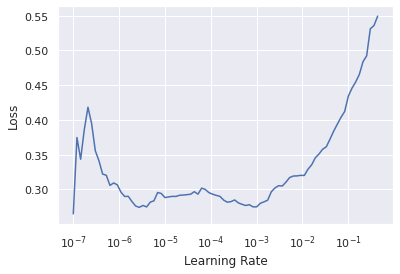

In [40]:
clas_learn.unfreeze()
clas_learn.lr_find()

In [41]:
clas_learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.304444,0.227567,0.910628,04:00
1,0.285433,0.222628,0.912473,03:59
2,0.260865,0.218463,0.913191,03:58


              precision    recall  f1-score   support

           1       0.92      0.90      0.91      4783
           2       0.91      0.92      0.92      4974

    accuracy                           0.91      9757
   macro avg       0.91      0.91      0.91      9757
weighted avg       0.91      0.91      0.91      9757



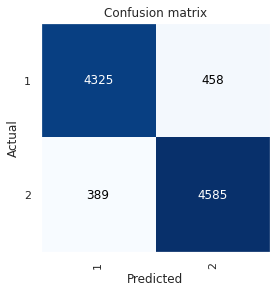

In [42]:
interp = ClassificationInterpretation.from_learner(clas_learn)

interp.print_classification_report()
interp.plot_confusion_matrix()

### Observation from LSTM
**The LSTM model has reached an accuracy of 91.3%, significantly higher than the baseline obtained by using text features and with much more homogeneous precision and recall for the two classes. It is worth observing that the validation dataset contains wrongly labeled samples, as we can see by analyzing the top losses.**

In [43]:
interp.plot_top_losses(k=8)

,input,target,predicted,probability,loss
0,xxbos xxmaj sensational . xxmaj this book is a riveting tale of suspense and adventure . xxmaj the ending made me cry . xxmaj beautiful !,1,2,0.999930739402771,9.577396392822266
1,xxbos xxmaj excellent . xxmaj this is a great book . xxmaj martha xxmaj beck is a wonderful writer with clear insight . a must read for anyone seeking their true path in life .,1,2,0.9998100399971008,8.568708419799805
2,xxbos outstanding . xxmaj five stars ! . xxmaj excellent instructions for applique with pictures to demonstrate their words . xxmaj basic applique primer . xxmaj your resource book .,1,2,0.9991171956062317,7.032437324523926
3,"xxbos typos galore ! . i do not intend to review content here . xxmaj this new edition is so full of typographical errors that sometimes the reader will have to intuit what the author really wrote . xxmaj it is clear that the proofreaders of this edition were not actually reading ; they were simply following the little red lines under the "" misspelled "" words . xxmaj this has resulted in some truly bizarre apparent statements by the author , xxunk here due to copyright laws . xxmaj xxunk i have not purchased this book , merely checked it out of the library .",2,1,0.9991135001182556,7.0282087326049805
4,xxbos xxmaj great easy to use . xxmaj have nt used yet but plan on soon it looks easy to use and i will soon but just have nt yet,1,2,0.9990056157112122,6.913374900817871
5,"xxbos xxmaj excellent ! . xxmaj this is one of the best books xxmaj i 've read on the subject . xxmaj everyone who is involved in any type of business research or competitor research can benefit from this book . xxmaj it even includes detailed descriptions of some of the best business information resources available , on- and offline .",1,2,0.9989963173866272,6.90410041809082
6,xxbos xxmaj interesting . xxmaj this book was a nice fast read . xxmaj not sure if i would recommend to my friends or not but it was interesting .,1,2,0.9973673224449158,5.939754486083984
7,"xxbos xxmaj good xxmaj ones . i bought these for my kids toys , been using these for almost 2 months now.i am happy with the product .",1,2,0.9959398508071899,5.5065178871154785


### 3.2 RoBERTa <a id=3.2></a>
Introduced at Facebook, Robustly optimized BERT approach RoBERTa, is a retraining of BERT with improved training methodology, 1000% more data and compute power.
To improve the training procedure, RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training and introduces dynamic masking so that the masked token changes during the training epochs. Larger batch-training sizes were also found to be more useful in the training procedure.

Let's see whether a transformer NN can further improve results. We use [RoBERTa](https://arxiv.org/abs/1907.11692), based on BERT architecture; I highly recommend the [blurr library](https://github.com/ohmeow/blurr) to integrate huggingface Transformers with fastai.

In [44]:
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification
from blurr.data.all import *
from blurr.modeling.all import *

pretrained_model_name = "roberta-base"
model_cls = AutoModelForSequenceClassification
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

In [45]:
dblock = DataBlock(blocks=(HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock), 
                   get_x=ColReader('text'), get_y=ColReader('label'),
                   splitter=IndexSplitter(range(train_len, len(df))))

dls = dblock.dataloaders(df, bs=4, dl_type=SortedDL)

dls.show_batch(dataloaders=dls)

,text,category
0,"A Strange Read. The Law and the Poor is an odd book. It enumerates some of the ways by which the British legal system into the 1920s either excluded or oppressed the poorer clases. Parry dwells at tedious length with the debacle that was debtors' prison, but has no solution but a belief that time will somehow mediate not only the problem of debtors' prison but all other legal inequities.What Parry expressed (repeatedly) could have been thoroughly covered in about 10 pages. Alas, his book was far longer than that.Only Parry's ability to cite from just about any text written after 1789 makes this book tolerable. I admittedly was amused at the succession of characters Parry inserted into his book. Unfortunately, if you are not extremely well-versed in Victorian history and literature, you'll miss much: Parry draws on the very obscure as often as he does on the famous. For me it was a hoot only because Victorian history is my field.The Kindle download is free; don't waste your money purchasing this book.",1
1,"So far so good. I purchased the RV042 specifically for failover between my cable modem and adsl line. Up until this point I'd been doing a manual failover. Also, I'd been hesitant to run a consumer router, instead always running a linux box for home routing/firewall needs.Out of the box it was very easy to setup the basics, emulate everything my linux box was doing at the time (incoming forwards, etc.), and within 1/2 hour was up-and-running. No complaints except I was unable to perform a firmware upgrade via a browser unless I fired up a VM and did it with Internet Explorer. Similar to my complaint with all Linksys products, they really need to stop developing for IE/Active crap and focus on actual web-standards - especially now with folks moving away entirely from Windows overall.Performance hasn't seemed to take a hit, and soon I'll setup the VPN and SNMP features so I can get some logging going. That's another complaint, no easy way to log or setup via a CLI - unless I missed something.",2
2,"Wizards First Rule = Fantasy flop!!!. Wizards First Rule (Book 1 of Terry Goodkinds 'Sword of Truth' series) is a classic example of yet another redundant fantasy ""epic"". One-dimensional and uninspired characters populate an unimaginative and cliched fantasy setting, and on top of it all Goodkind writes with the stylistic flair of a 3rd grader. Seriously, the writing is ridiciously poor. I am a HUGE fantasy and sci-fi fan, and after hearing rave reviews I picked this novel up. Somehow I managed to slog my way through the entire book, which incidentally is about 500 pages too long, and as far as I can tell it has very little positive elements at all. Prepubescent teens looking for gratuitous violence, and cliched characters will be extremely pleased with this book. Other readers looking for something more imaginative, entertaining, and intellectual than this piece of literary [junk], would do well to check out George R.R Martin's ""A Game of Thrones"", or anything by Guy Gavriel Kay.",1
3,"Fun for serious football fans/gamers. I have owned a lot of soccer games and to be brief:This game is a pleasure to play if you are a serious footie gamer.The new manager mode is a great and it really keeps you playing the game for a longer period of time. As far as goals are concerned, the defense is much harder this year and while on the easiest level you can blast the ball by keepers from 20 yards out, its much harder on the top skill levels. I think its very realistic because in the actual game of football, i think you see more goals as a result of headers, fastbreaks, and defensive break downs that let a player get behind the opposition and up close to the goal within the 8 yard box more than you will see 20-25 yard screamers. This game shows that as the goalies are not soo easily fooled at long range when you get into the two higher skill levels.If you want a challenge with managing contracts and funds while competing for 

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=0.02290867641568184)

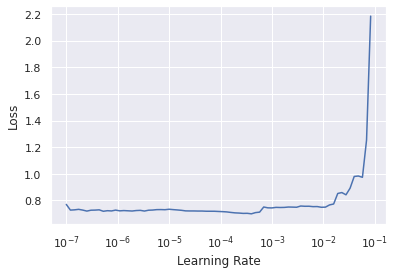

In [46]:
roberta_model = HF_BaseModelWrapper(hf_model)

roberta_learn = Learner(dls, 
                roberta_model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy,
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

roberta_learn.freeze()

roberta_learn.lr_find()

In [47]:
roberta_learn.fit_one_cycle(1, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.112342,0.112040,0.960951,15:39


SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=9.12010818865383e-07)

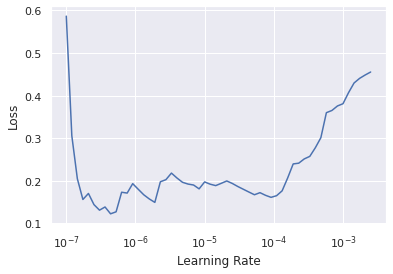

In [48]:
roberta_learn.freeze_to(-2)
roberta_learn.lr_find()

In [49]:
roberta_learn.fit_one_cycle(1, lr_max=3e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.123497,0.103549,0.963411,24:40


In [50]:
roberta_learn.unfreeze()
roberta_learn.fit_one_cycle(2, lr_max=slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.091502,0.105302,0.965563,25:18
1,0.043176,0.107486,0.964333,25:44


In [51]:
preds = roberta_learn.blurr_predict(dls.valid.items)

pred_proc = np.array([int(dls.categorize.decode(a)) for i in list(zip(*preds))[1] for a in i])

true_y = dls.valid.items['label'].values

print(classification_report(true_y, pred_proc))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96      4783
           2       0.96      0.97      0.97      4974

    accuracy                           0.96      9757
   macro avg       0.96      0.96      0.96      9757
weighted avg       0.96      0.96      0.96      9757



Finetuning a pretrained transformer architecture leads to an accuracy of **96.5%**, much better than what we achieved with a LSTM RNN. 

*****************************
### 3.3 Model Comparison
So far, we have developed **Deep Learning Models**, and the models are now being checked by their accuracy scores. So, let's get to the comaparison of the deployed models.

|Models|Accuracy Score|
|:-:|:-:|
|LSTM Reccurent Neural Network|91.00|
|RoBERTa Model|96.50|

### Observation
As the accuracy score provides that the RoBERTa transformer architecture leads to an accuracy of 96.5%, much better than what we achieved with a LSTM RNN.

******************************
## 4. Overall Comparison!
We have developed five text vectorization models and two deep learning models, all total we have deployed seven machine learning + deep learning models. Now let's find out which one is the best among all these!

|Models|Accuracy Score|
|:-:|:-:|
|CountVectorizer + MultinomialNB|89.06|
|TfidfVectorizer + MultinomialNB|89.08|
|CountVectorizer + MultinomialNB w/o stopwords|87.63|
|TfidfVectorizer + MultinomialNB w/o stopwords|87.59|
|CountVectorizer + MultinomialNB lemmatized|88.48|
|LSTM Reccurent Neural Network|91.00|
|RoBERTa Model|96.50|

*********************************************

## 5. Conclusion
* From all the deployed models it is clear that the **deep learning methods are having the upper hand over the Text Vectorization models in this case.**
* Text vectorization models have achieved the best score of **89.08**, which is scored by, **TfidfVectorizer + MultinomialNB** model.
* Deep learning models are having the higher accuracy than the vectorizations, as **RoBERTa architecture** is the best among them with **96.50** accuracy score.
* **RoBERTa is the best model for this classification model for the Amazon Products Reviews Classification.**

**************************************************

### Hope this project will help you. Thank you!
